# Statistics for Time Series Predicition

### Importing the main libraries

In [1]:
import numpy as np                              
import pandas as pd                             
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error               
import tensorflow as tf
import os


### Simple predicition methods

In [2]:
#Simple predicition
def BaseModel(series):
    N = len(series)
    y = series.copy()
    for t in range(1, N):
        y.iloc[t] = series.iloc[t-1]
    return y

# Sazonal predicition
def SazonalBaseModel(series, s):
    N = len(series)
    y = series.copy()
    for t in range(s, N):
        y.iloc[t] = series.iloc[t-s]
    return y

#Trend predicition
def trend_model(series,m):
    N = len(series)
    y = series.copy()
    for t in range(1, N):
        y.iloc[t] = series.iloc[t-1] + (series.iloc[t-1] - series.iloc[t-m])/(m-1)
    return y

### MAPE (Mean Absolute Error Percentage)

In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / np.mean(y_true))) * 100

### Beer production Series

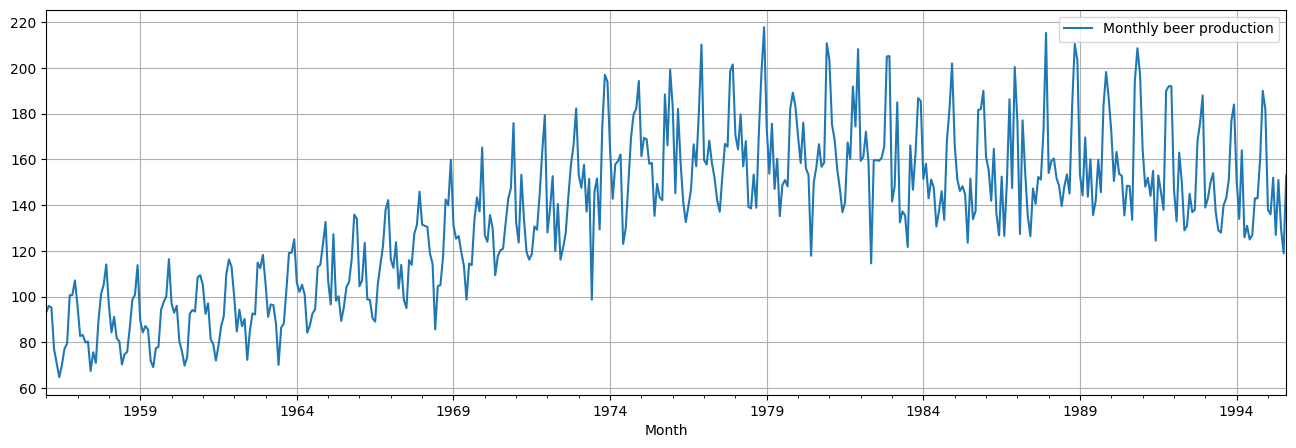

In [4]:
df_beer = pd.read_csv('monthly-beer-production-in-austr.csv')

#Getting the month column
month = pd.to_datetime(df_beer.pop('Month'))

# data series plot
plot_cols = ['Monthly beer production']
plot_features = df_beer[plot_cols]
plot_features.index = month
_ = plot_features.plot(subplots=True, figsize=(16, 5))
plt.grid(True)
 
y_base_beer = BaseModel(df_beer['Monthly beer production'])

y_trend_beer = trend_model(df_beer['Monthly beer production'], 2)

y_sazonal_beer = SazonalBaseModel(df_beer['Monthly beer production'], 12)

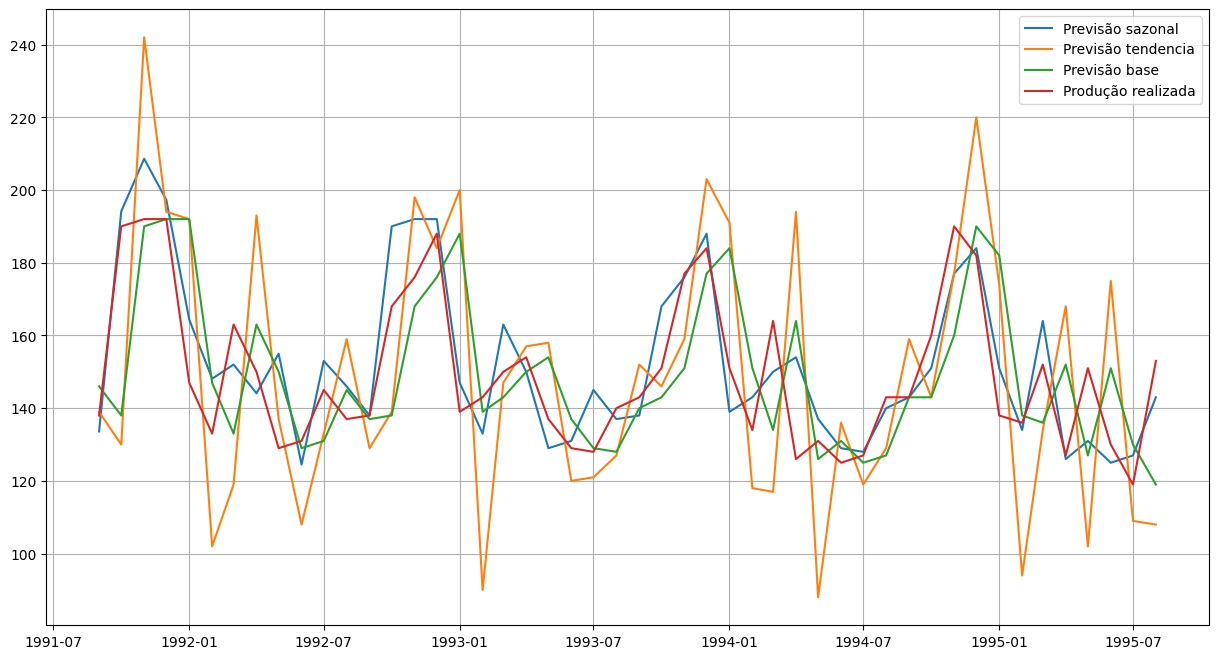

Sazonal prediction: 143.0
Trend Prediction: 108.0
Base prediction: 119.0
Real production 153.0


In [5]:
plt.figure(figsize=(15, 8))
plt.plot(month[-48:],y_sazonal_beer[-48:],label='Previsão sazonal')
plt.plot(month[-48:],y_trend_beer[-48:],label='Previsão tendencia')
plt.plot(month[-48:],y_base_beer[-48:],label='Previsão base')
plt.plot(month[-48:],df_beer['Monthly beer production'][-48:],label='Produção realizada')
plt.grid(True)
plt.legend()
plt.show()

print("Sazonal prediction:", y_sazonal_beer[-1:].values[0])
print("Trend Prediction:", y_trend_beer[-1:].values[0])
print("Base prediction:", y_base_beer[-1:].values[0])
print("Real production", df_beer['Monthly beer production'][-1:].values[0])

In [6]:
sazonal_MAPE = mean_absolute_error(df_beer['Monthly beer production'],y_sazonal_beer)
trend_MAPE = mean_absolute_error(df_beer['Monthly beer production'],y_trend_beer)
base_MAPE = mean_absolute_error(df_beer['Monthly beer production'],y_base_beer)

print("Sazonal prediction MAPE:", sazonal_MAPE,"%")
print("Trend prediction MAPE:", trend_MAPE,"%")
print("Base prediction MAPE:", base_MAPE,"%")

Sazonal prediction MAPE: 9.122899159663865 %
Trend prediction MAPE: 23.70084033613445 %
Base prediction MAPE: 14.835714285714284 %


In this case we see that with just a simple method we can predict values with a small percentage error. Sometimes we can just use statistics instead ML or DL models. It's less precise, in contrast requires a smaller amount of data and is faster.

### Temperature Series

Here we'll analyse the temperature serie using only statistics, but first we need to process the inconsist data.
We are talking about temperature so I'll use the mean of the next neighbors of the inconsist line in order to avoid problems in our forecast

In [7]:
def filter_non_float_and_replace_with_mean(column):
    filtered_values = []
    none_indices = []
    
    for i, value in enumerate(column):
        try:
            float_value = float(value)
            filtered_values.append(float_value)
        except ValueError:
            filtered_values.append(None)
            none_indices.append(i)
    
    for idx in none_indices:
        prev_index = idx - 1
        next_index = idx + 1
        prev_value = None if prev_index < 0 else filtered_values[prev_index]
        next_value = None if next_index >= len(filtered_values) else filtered_values[next_index]
        
        if prev_value is not None and next_value is not None:
            mean_value = (prev_value + next_value) / 2
            filtered_values[idx] = mean_value
        elif prev_value is not None:
            filtered_values[idx] = prev_value
        elif next_value is not None:
            filtered_values[idx] = next_value
    
    return filtered_values

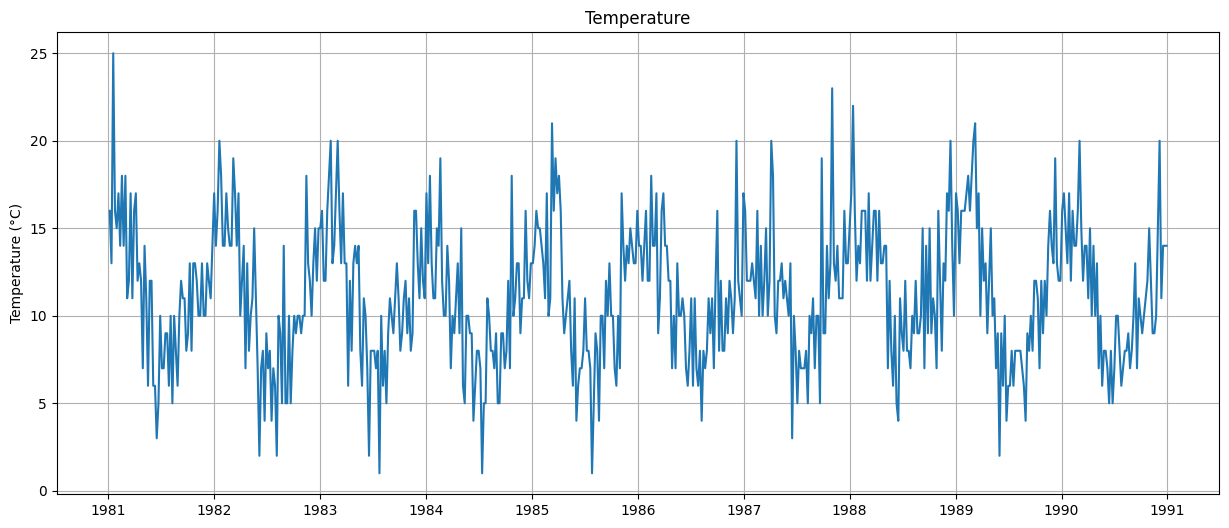

In [8]:
df_temp = pd.read_csv("daily-minimum-temperatures-in-me.csv", sep=",")

df_temp["Daily minimum temperatures"] = filter_non_float_and_replace_with_mean(df_temp['Daily minimum temperatures'])
df_temp = df_temp[5::6]

date_time = pd.to_datetime(df_temp.pop('Date'), format='%m/%d/%Y')

plt.figure(figsize=(15, 6))
plt.title('Temperature')
plt.plot(date_time, df_temp['Daily minimum temperatures'].round().astype(int))
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()

Moving average

The moving average model is an extension of the base method. It is one of the most used techniques for time series due to its simplicity combined with its ability to provide important parameters for analyzing a time series.
 
The moving average model assumes that the future value of the variable depends on the average of its previous values, according to the equation:

$$\hat{y}_{t} = \frac{1}{m}\displaystyle\sum^{m}_{i=1} y_{t-i}$$
   
where $m$ is the number of previous samples considered in calculating the mean. The value of $m$ must be chosen depending on the behavior of the series.


In [9]:
def moving_average(series, m):
  N = len(series)
  y = series.copy()
  for t in range(m,N):
    y.iloc[t]= np.average(series[t-m:t])
  return y 

Let's caculate a forecast using the last 4 days

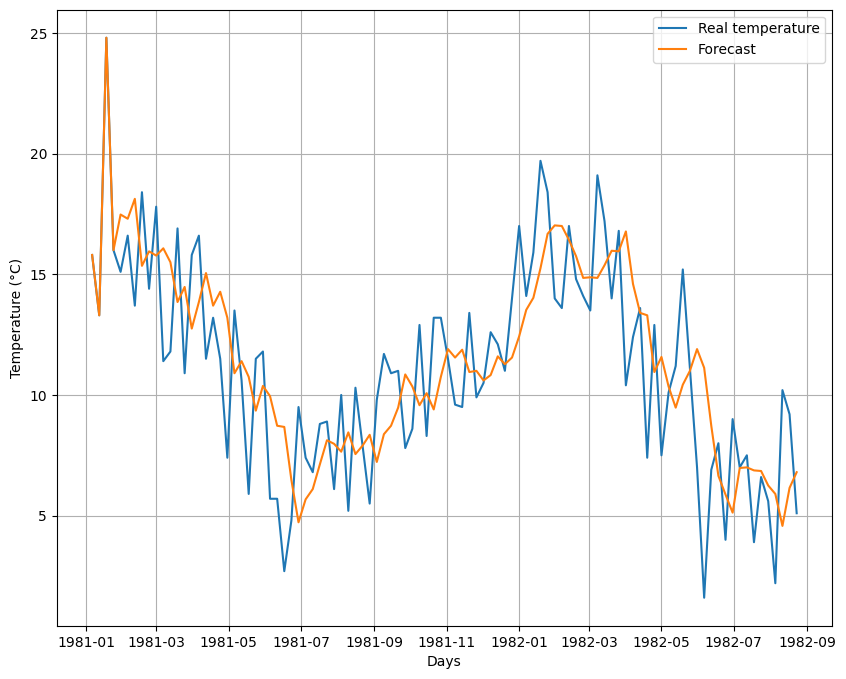

In [10]:
m = 4
y_prev = moving_average(df_temp['Daily minimum temperatures'],m)

# Visualização gráfica
plt.figure(figsize=(10, 8))
plt.plot(date_time.iloc[:100], df_temp['Daily minimum temperatures'].iloc[:100], label='Real temperature')
plt.plot(date_time.iloc[:100], y_prev.iloc[:100], label='Forecast')
plt.ylabel('Temperature (°C)')
plt.xlabel('Days')
plt.grid(True)
plt.legend()
plt.show()

In [11]:
error = 100*mean_absolute_error(df_temp['Daily minimum temperatures'],y_prev) / np.mean(df_temp['Daily minimum temperatures'])
print(f'Error moving average = {np.array(error):.2f}%')

Error moving average = 21.26%


Note that this moving average model only predicts the next future value and is not capable of making long-term predictions, since, to obtain the value at the next instant of time, previous data must be available.

However, the moving average model can be used for other purposes. Such as, for example, smoothing the original series in order to identify trends and *outliers*. 

A striking characteristic of the moving average is the fact that the larger the window adopted, the smoother the behavior of the series becomes. In the case of data affected by a lot of noise, which occurs frequently, this method can help identify the patterns contained in the data.

### Moving average with pandas  

The code below implements the moving average calculation using a Pandas function. It also calculates the lower and upper limits, defined as variations of multiples of the standard deviation of the error.

In [12]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    """
    series - series dataset
    window - length of the sliding window (number of past values ​​used to calculate the moving average) 
    plot_intervals - shows confidence intervals 
    scale - multiplication factor to calculate confidence interval 
    plot_anomalies - displays anomalies
    """
    # Calculate moving average
    moving_average = series.rolling(window=window, closed='left').mean()
    # Visualization
    plt.figure(figsize=(15, 6))
    plt.title(f'Moving average \n (window length = {window})')
    plt.plot(moving_average, "g", label="Trend moving average")

    # Calculates confidence interval for the smoothed series using a standard deviation
    if plot_intervals:
        mae = mean_absolute_error(series[window:], moving_average[window:])
        desviation = np.std(series[window:] - moving_average[window:])
        lower_limit = moving_average - (mae + scale * desviation)
        upper_limit = moving_average + (mae + scale * desviation)
        plt.plot(upper_limit, "r--", label="Upper limit / Lower limit")
        plt.plot(lower_limit, "r--")
        
        # Identifies anomalies, considering that they are values ​​that exceed confidence levels
        if plot_anomalies:
            anomalies = np.nan*series.copy()
            anomalies[series<lower_limit] = series[series<lower_limit]
            anomalies[series>upper_limit] = series[series>upper_limit]
            plt.plot(anomalies, "ro", markersize=10)
                        
            outliers = anomalies.dropna()
            print("Outliers values:")
            print(outliers)
        
    plt.plot(series[window:], label="Real values")
    plt.legend(loc="upper left")
    plt.grid(True)

Smoothing of the temperature series using the last 4 data to calculate the moving average is performed below.

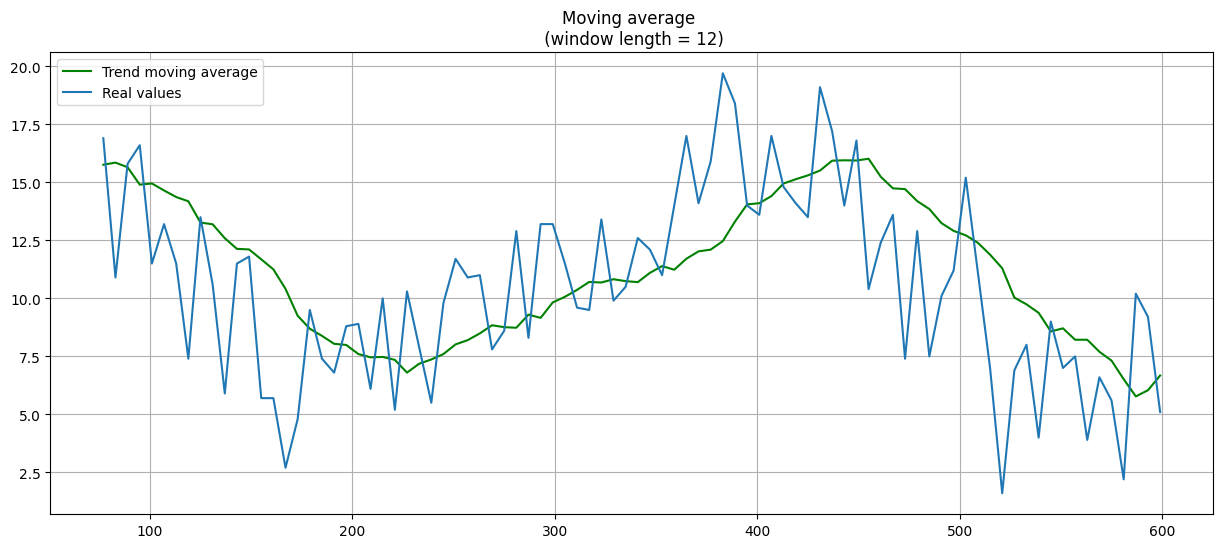

In [13]:
plotMovingAverage(df_temp['Daily minimum temperatures'].iloc[:100], 12) 

As data is collected every hour, if the previous 24 data are used to calculate the moving average, the daily trend of the series is obtained.

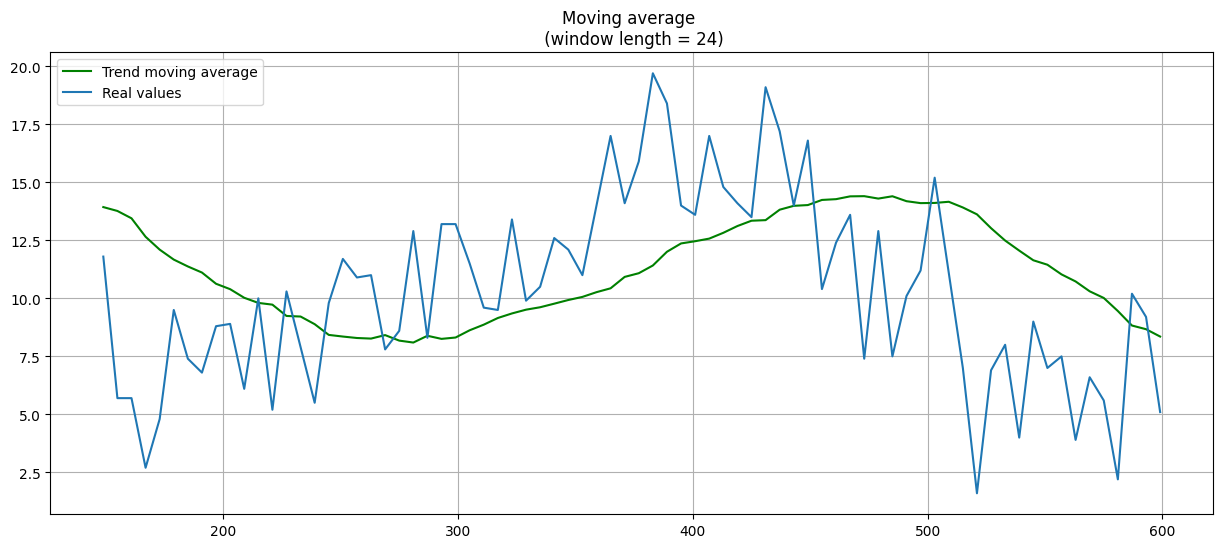

In [14]:
plotMovingAverage(df_temp['Daily minimum temperatures'].iloc[:100], 24)

When using daily smoothing of data collected every hour, it is possible to more easily verify the dynamics of temperature variation, which, during this period, tends to increase.

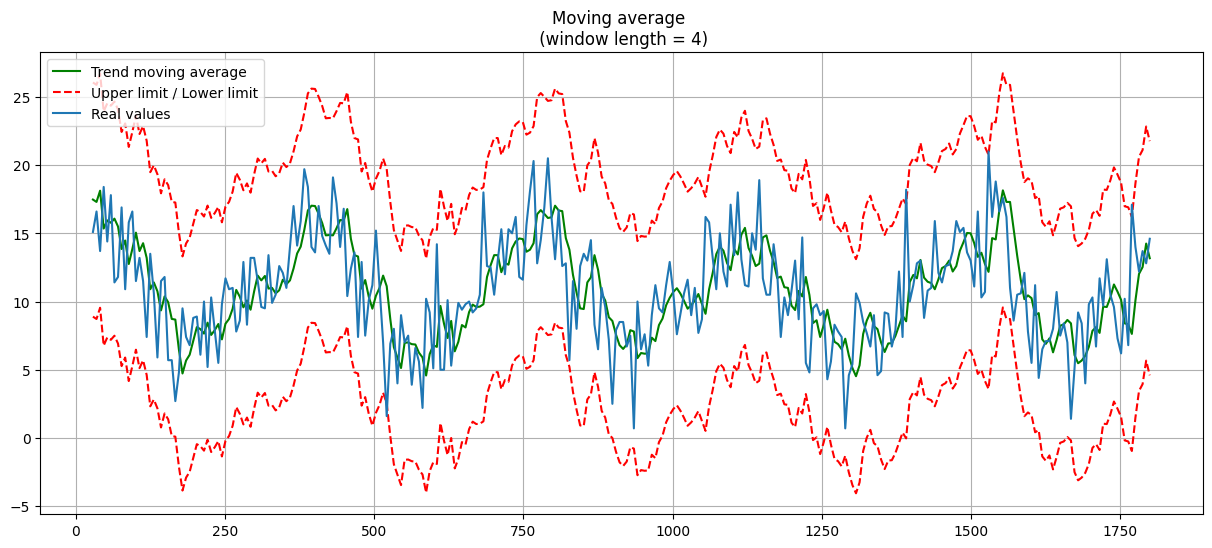

In [15]:
plotMovingAverage(df_temp['Daily minimum temperatures'].iloc[:300], 4, plot_intervals=True)


using confidence intervals we can already say that there are outliers in our data

## Outliers detection


Let's check if any anomalies are detected in the temperature series using the moving average forecasting method. To do this, we will call the `plotMovingAverage` function, with a 4-hour window, with the options to include upper and lower confidence levels and anomaly detection. Remember that this data is collected every hour.

Outliers values:
521      1.6
1391    18.2
1529    21.0
1769    17.1
2165    20.2
Name: Daily minimum temperatures, dtype: float64


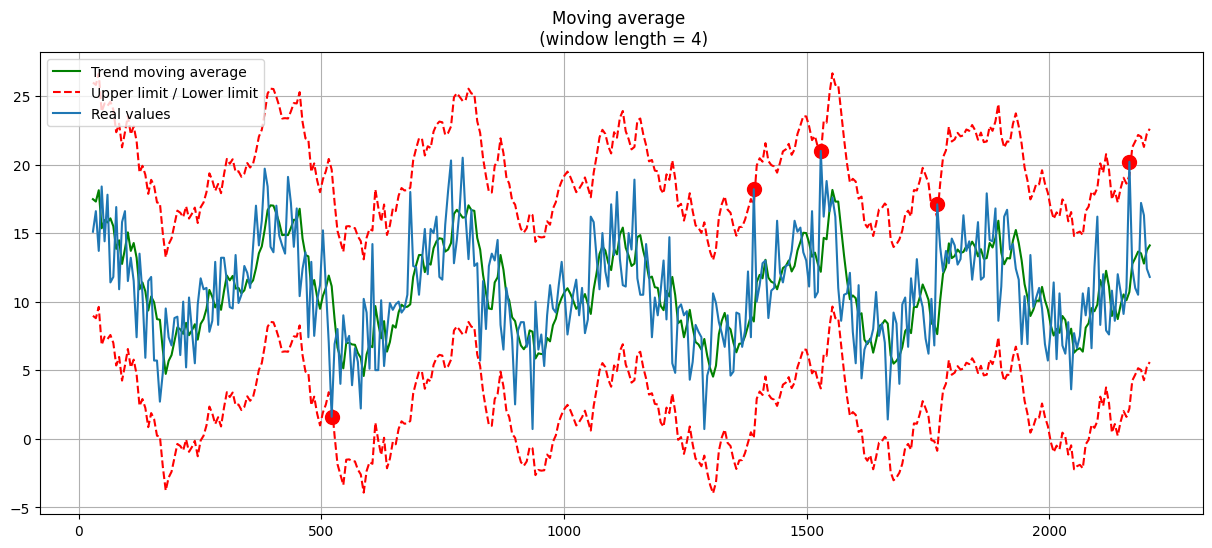

In [16]:
plotMovingAverage(df_temp['Daily minimum temperatures'].iloc[:368], 4, plot_intervals=True, plot_anomalies=True)
